# PI de Algotrading - Antonio Fuziy

___


Entrega de um Projeto de Simulação em duas etapas:

    - Mesclar três indicadores técnicos para uma decisão de direção
    - Se desejar, dos indicadores dados em aula (MACD, RSI e Bollinger Bands), você pode escolher apenas 1 para usar
    - Cada indicador contribui com um sinal, você deve montar uma forma de juntá-los, explicando o processo
    - Você tem que modular para o tamanho da alocação para refletir a indicação do modelo. Por exemplo, se pelo os três indicadores indicam compra, deve-se comprar mais
    - Escolher um período entre 5 e 10 anos com dados diários e simular com 3 Ativos diferentes
    - O seu modelo deve fazer Stop Gain e Stop Loss, você deve explicar o processo de escolha dos níveis

Entrega: PDF do notebook no dia 13/Abr às 23:59 no BLACKBOARD Estritamente individual
Modelo sugerido do Notebook:

    - introdução (sobre o que é seu estudo)
    - metodologia (como funcionam os indicadores, como você fundiu os sinais, como dimensionou o size)
    - resultados (como foi a performance para os 3 casos)
    - conclusão (o que pode tirar desse estudo e como melhorá-lo)



___

## Introdução

Os indicadores técnicos apresentam um papel fundamental para estudos de mercado, principalmente para o mercado de trade, eles podem ser definidos como heurísticas ou padrões baseados em sinais produzidos por dados de um ativo, como volatilidade, preço, volume e muitos outros. Este relatório tem como objetivo, mostrar alguns indicadores técnicos e fundi-los em uma estratégia de algotrading, dessa forma é possível prever comportamentos futuros de três ativos através desses indicadores.

Para que esse estudo fosse possível, utilizou-se a linguagem de programação Python e a ferramente mais utilizada para esse relatório foi a biblioteca `pandas-ta`, uma biblioteca derivada do `pandas`, porém voltada para análise técnica através de indicadores.

Para esse documento utilizou-se três indicadores técnicos, dentre eles estão: 

- Chande Momentum Oscillator **(CMO)**

- Percentage Price Oscillator **(PPO)**

- Bollinger Bands **(BBANDS)**

___

## Metodologia

Esses três indicadores são classificados em categorias, sendo o **CMO** e o **PPO** indicadores de **Momentum** enquanto o **Bollinger Bands** é classificado como indicador de **Volatilidade**.

Os indicadores de Momentum são indicadores técnicos que determinam subidas ou caídas de ativos enquanto os indicadores de Volatilidade determinam trades ótimos de saída ou entrada, identificando casos de muita variação de preço seja ela alta ou baixa.

Entrando mais a fundo nos indicadores escolhidos para o estudo é importante descrever como cada um funciona. Portanto, segue abaixo a explicação de cada indicador:

### Percentage Price Oscillator (PPO)

O PPO utiliza duas médias móveis exponenciais (EMAs) para calcular a diferença em porcentagem das duas EMAs. Seu cálculo é muito similar ao MACD, porém o MACD utiliza a diferença absoluta das duas médias móveis exponenciais. O PPO gera sinais compra e de venda, quando a linha de cálculo do PPO cruza a  

![ppo.png](ppo.png)

Importando as bibliotecas utilizadas 

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import random
import yahoofinancials as yf
import pandas_ta as ta

# Para fazer o backtesting
from backtesting_v2 import evaluateHist, evaluateIntr, Strategy, Order

plt.style.use("dark_background")

In [2]:
tickers = ["TSLA", "META", "NKE"]

In [3]:
start_date = '2017-03-06'
end_date =  '2022-03-06'

for ticker in tickers:
    data = yf.YahooFinancials(ticker).get_historical_price_data(start_date, end_date, 'daily')

    # Ler os dados do JSON
    raw = pd.DataFrame(data[ticker]['prices']).dropna()
    # Converter a data para o tipo correto datetime
    raw['formatted_date'] = pd.to_datetime(raw['formatted_date'])
    # Indica a data como o índice de cada linha
    raw = raw.set_index('formatted_date')
    # Removendo as colunas que não interessam
    df = raw.iloc[:,1:]

    # Acertando a ordem das colunas
    df = df.reindex(columns=['open', 'high', 'low', 'close', 'adjclose', 'volume'])
    # Salvando o CSV
    df.to_csv('{}.csv'.format(ticker))

In [4]:
df = pd.read_csv('{}.csv'.format(ticker))
df.head()

,formatted_date,open,high,low,close,adjclose,volume
0,2017-03-06,56.700001,56.930000,56.529999,56.770000,53.334351,6896800
1,2017-03-07,56.709999,56.990002,56.020000,56.549999,53.127670,7124400
2,2017-03-08,56.939999,56.939999,56.310001,56.509998,53.090088,7604800
3,2017-03-09,56.610001,56.660000,56.090000,56.360001,52.949173,6165700
4,2017-03-10,56.490002,56.990002,56.259998,56.430000,53.014931,8882400


In [5]:
class FuziyStrategy(Strategy):
    def __init__(self):
        # Quantidade de dias de cada média móvel
        self.period = 14
        
        self.sell_signals = []
        self.buy_signals = []
        
        #====================================================================
        #BOLLINGER BANDS PARAMETERS
        #====================================================================
        self.m = 1 # testar 1.5
        self.prices = []
        
        self.bbands_indicator = []
        self.bbands_signal = 0
        
        #====================================================================
        #CMO PARAMETERS
        #====================================================================
        self.cmo_indicator = []
        self.cmo_signal = 0
        
        #====================================================================
        #PPO PARAMETERS
        #====================================================================
        self.ppo_fast = 12
        self.ppo_slow = 26
        self.ppo_signal = 9
        self.ppo_scalar = 100
        self.ppo_indicator = []
        self.ppo_signal = 0
        
        #INIT CAPITAL TO AVOID CARRY
        self.init_capital = 1000
        self.avail_capital = self.init_capital
        
        # Side da estratégia (+1 Compra/-1 Vende)
        self.side = -1


    def receive(self, event):
        
        price = event.price[3] # Captura o preço atual vindo do evento
        
        # Montando a série de preços:
        self.prices.append(price)
        
        #====================================================================
        #BOLLINGER BANDS
        #====================================================================
        # Se a quantidade de preços observados for superior a janela
        if len(self.prices) >= self.period + 1:
            
            # Monta a lista de preços em um dataframe
            close = pd.DataFrame({'close': self.prices})
            
            bbands = close.ta.bbands(lenght = self.period, std = self.m)            
            
            down = bbands.iloc[-1, 0]
            avg = bbands.iloc[-1, 1]
            up = bbands.iloc[-1, 2]
            
            # Guarda os dados para o gráfico
            self.bbands_indicator.append([up, avg, down])
#             print(f"BBANDS ARRAY VALUE: {self.bbands_indicator}")
                                                
            # Se o preço estiver abaixo da banda inferior compra, senão vende
            if price < down:
                self.bbands_signal = -1 
            elif price > up:
                self.bbands_signal = 1
            elif price > avg and self.side == -1:
                self.bbands_signal = 0
            elif price < avg and self.side == 1:
                self.bbands_signal = 0
            else:
                self.bbands_signal = self.side
            
        #====================================================================
        #CMO
        #====================================================================
        if len(self.prices) >= self.period + 1:
            close = pd.DataFrame({'close': self.prices})
            cmo = close.ta.cmo(length=self.period)
            self.cmo_indicator.append([cmo.iloc[-1]])
            
            cmo_value = cmo.iloc[-1]
#             print(f"CMO VALUE: {cmo_value}")
            
            if cmo_value >= 50: 
                self.cmo_signal = 1
            elif cmo_value <= -50:
                self.cmo_signal = 0

        #====================================================================
        #PPO
        #====================================================================
        if len(self.prices) >= self.ppo_slow + self.ppo_signal:
            close = pd.DataFrame({'close': self.prices})
            
            ppo = close.ta.ppo(fast=self.ppo_fast, slow=self.ppo_slow, signal=self.ppo_signal, scalar=self.ppo_scalar)
            
            self.ppo_indicator.append([ppo.iloc[-1, 0], ppo.iloc[-1, 2]])
            
            self.ppo_signal = ppo.iloc[-1, 0] > ppo.iloc[-1, 2]
            
#             print(f"PPO SIGNAL: {self.ppo_signal}")

        combined_signals = self.cmo_signal + self.ppo_signal + self.bbands_signal
#         if self.side != combined_signals:
#             if self.side == 1:
#                 self.submit(self.id, Order(event.instrument, Order.S, self.side, 0))
# #                 self.sell_signals.append(price)
#                 print(f"Sell for {price}")
#                 self.side = 1
#             elif self.side == -1:
#                 self.submit(self.id, Order(event.instrument, Order.B, -self.side, 0))
# #                 self.buy_signals.append(price)
#                 print(f"Bought for {price}")
#                 self.side = -1
#             print(combined_signals)

        if (combined_signals == 3 or combined_signals == 2) and self.side == -1:
            self.submit(self.id, Order(event.instrument, Order.B, combined_signals, 0))
#                 self.buy_signals.append(price)
#                 print(f"Bought for {price}")
            self.side = 1
        elif combined_signals == 2 and self.side == 1:
            self.submit(self.id, Order(event.instrument, Order.S, combined_signals, 0))
#                 self.sell_signals.append(price)
#                 print(f"Sell for {price}")
            self.side = -1

        elif combined_signals == 3 and self.side == 1:
            self.submit(self.id, Order(event.instrument, Order.SS, -combined_signals, 0))
#                 self.sell_signals.append(price)
#                 print(f"Sell for {price}")
            self.side = -1
        combined_signals = 0

                
#             self.side = combined_signals
            

fuziy_strategy = FuziyStrategy()

print(evaluateHist(fuziy_strategy, {'TSLA': 'TSLA.csv'}))

Gross Profit: $3319.22
Gross Loss: $-29.89
Gross Total: $3289.32

Number of trades: 11
Hitting Ratio: 54.55%
Number of profit trades: 6
Number of loss trades: 5
Average number of events per trade: 111.18

Max win trade: $3302.19
Avg win trade: $553.20
Max loss trade: $-12.64
Avg loss trade: $-5.98
Avg all trades: $299.03
Win/Loss ratio: 92.53

Max Profit: $7199.01
Max Profit High/Low: $7321.23
Max Drawdown: $-110.69
Max Drawdown High/Low: $-117.11

Max Allocation: $5638.59
Avg Allocation: $594.16
Max Cash Required (margin): $5638.59

Gross Total: $3289.32
Total Fees: $47.40
Total Taxes: $558.34
Net Total: $2683.58

Gross Return: 43.73%
Average Return: 3.98%
Net Return: 2.27%
Net Return Avg Alocation: 451.66%

Number of days: 1260
Initial Capital: $1000.00
Risk Free Rate: 13.75% yearly/0.0511% daily
Total Carry: $127.05
Net Total + Carry: $2810.63
Net Return Capital: 281.06%
Net Return Capital Yearly: 30.68%




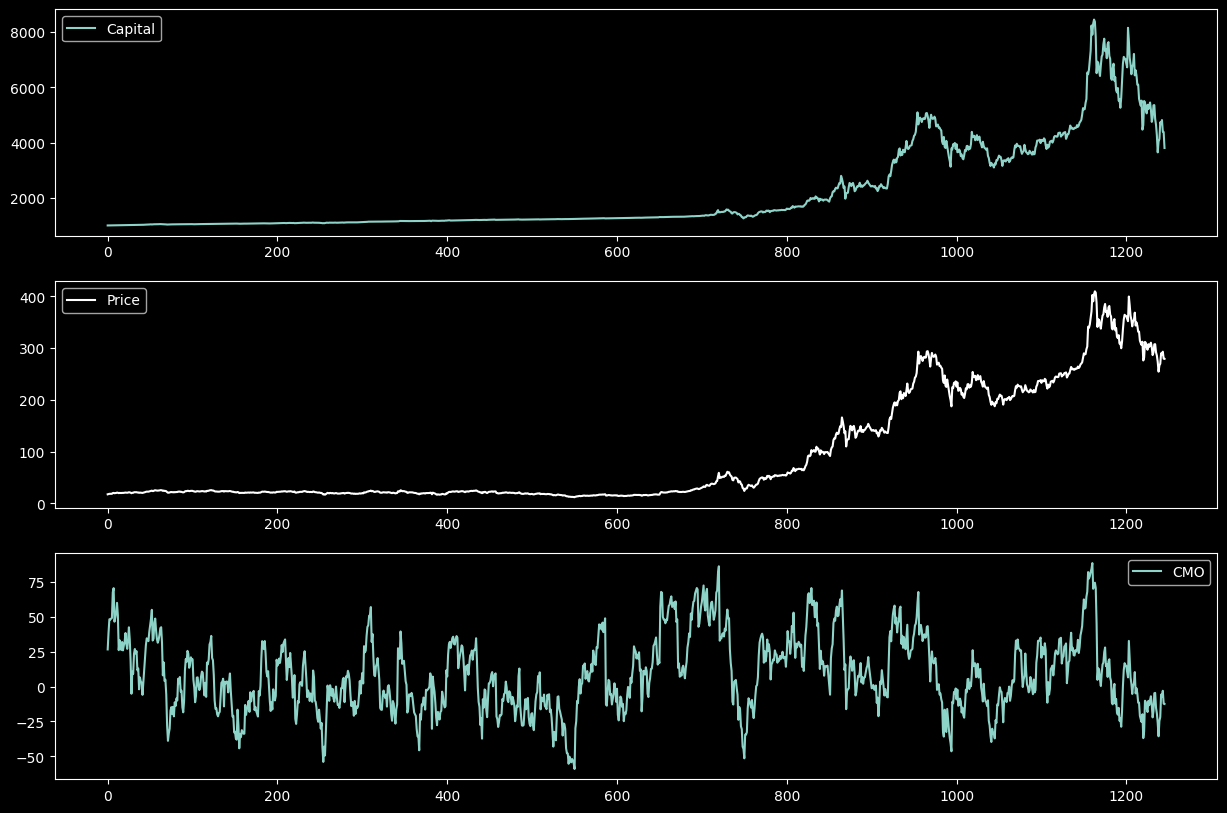

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(15,10));

ax[0].plot([day[0] for day in fuziy_strategy._days.values()][-len(fuziy_strategy.cmo_indicator):])
ax[0].legend(['Capital']);
ax[1].plot(fuziy_strategy.prices[-len(fuziy_strategy.cmo_indicator):], color='white');
ax[1].legend(['Price']);
ax[2].plot(fuziy_strategy.cmo_indicator);
ax[2].legend(['CMO', 'signal']);

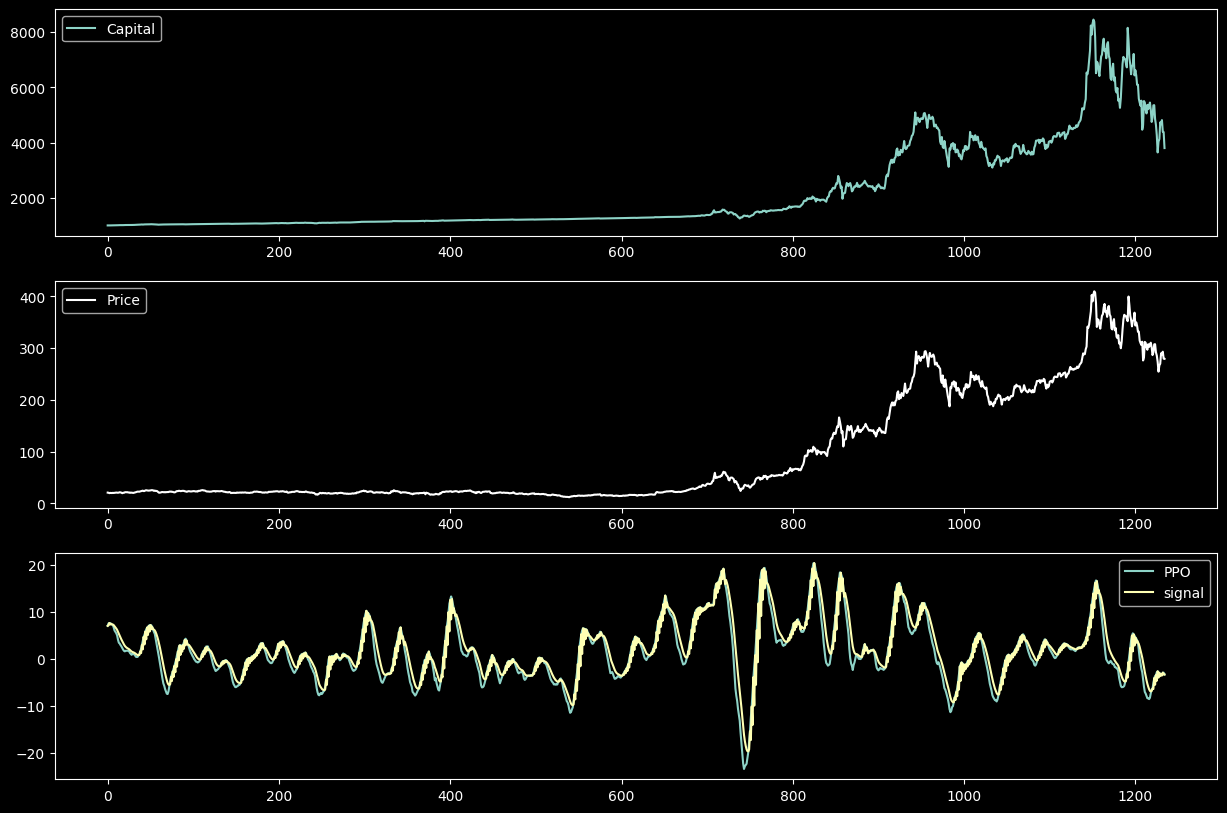

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(15,10));

ax[0].plot([day[0] for day in fuziy_strategy._days.values()][-len(fuziy_strategy.ppo_indicator):])
ax[0].legend(['Capital']);
ax[1].plot(fuziy_strategy.prices[-len(fuziy_strategy.ppo_indicator):], color='white');
ax[1].legend(['Price']);
ax[2].plot(fuziy_strategy.ppo_indicator);
ax[2].legend(['PPO', 'signal']);

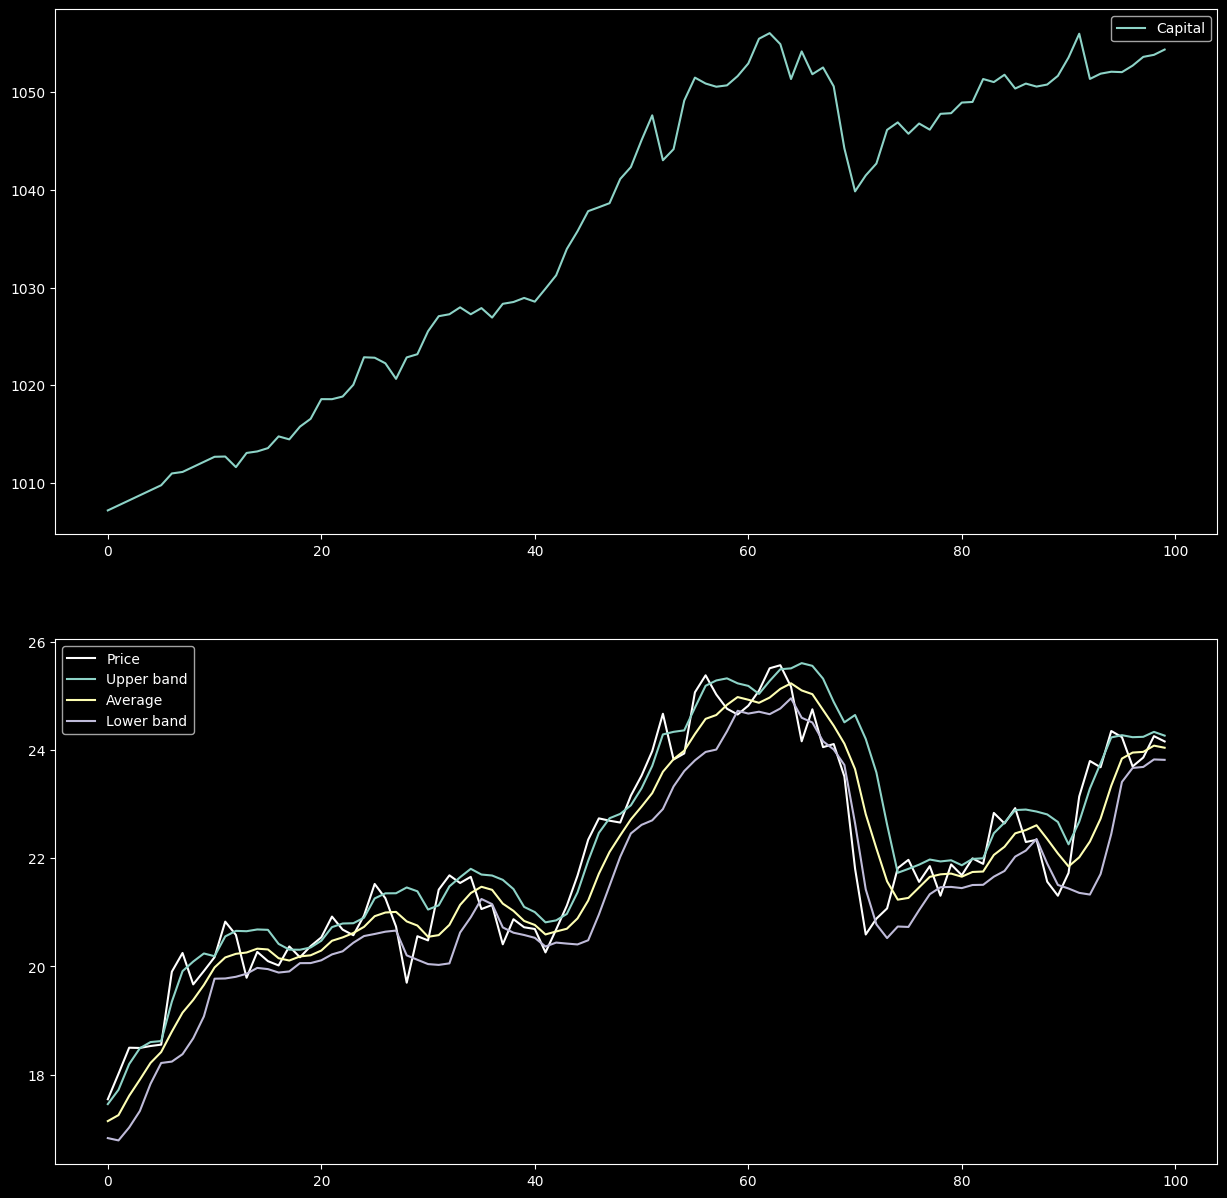

In [8]:
# Plot do gráfico
fig, ax = plt.subplots(2, 1, figsize=(15,15));

shift = -len(fuziy_strategy.bbands_indicator)
ax[0].plot([day[0] for day in fuziy_strategy._days.values()][shift:100+shift])
ax[0].legend(['Capital']);
ax[1].plot(fuziy_strategy.prices[shift:100+shift], color='white');
ax[1].plot(fuziy_strategy.bbands_indicator[:100]);
ax[1].legend(['Price', 'Upper band', 'Average', 'Lower band']);

In [9]:
fuziy_strategy = FuziyStrategy()

print(evaluateHist(fuziy_strategy, {'META': 'META.csv'}))

Gross Profit: $80.57
Gross Loss: $-0.92
Gross Total: $79.65

Number of trades: 10
Hitting Ratio: 90.00%
Number of profit trades: 9
Number of loss trades: 1
Average number of events per trade: 120.60

Max win trade: $51.36
Avg win trade: $8.95
Max loss trade: $-0.92
Avg loss trade: $-0.92
Avg all trades: $7.96
Win/Loss ratio: 9.73

Max Profit: $4731.61
Max Profit High/Low: $4787.77
Max Drawdown: $-916.94
Max Drawdown High/Low: $-936.61

Max Allocation: $6802.74
Avg Allocation: $974.66
Max Cash Required (margin): $6802.74

Gross Total: $79.65
Total Fees: $55.00
Total Taxes: $148.33
Net Total: $-123.68

Gross Return: 7.72%
Average Return: 0.77%
Net Return: 2.20%
Net Return Avg Alocation: -12.69%

Number of days: 1260
Initial Capital: $1000.00
Risk Free Rate: 13.75% yearly/0.0511% daily
Total Carry: $-2253.91
Net Total + Carry: $-2377.59
Net Return Capital: -237.76%
Net Return Capital Yearly: nan%




/home/antonio/Desktop/algotrading/entrega3/backtesting_v2.py:453: RuntimeWarning: invalid value encountered in scalar power
  res += 'Net Return Capital Yearly: {0:.2f}%\n\n'.format(100*((1+ret_cap)**(252/len(self._days))-1))


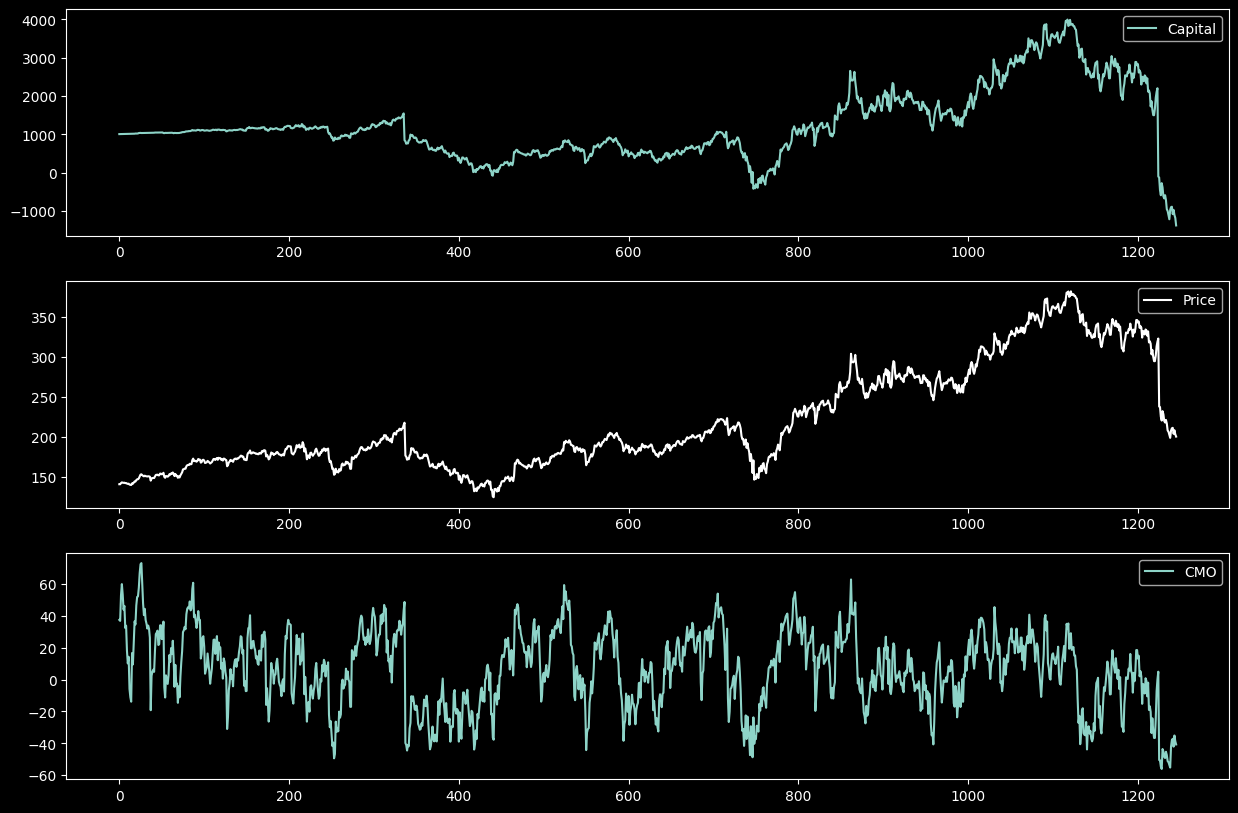

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(15,10));

ax[0].plot([day[0] for day in fuziy_strategy._days.values()][-len(fuziy_strategy.cmo_indicator):])
ax[0].legend(['Capital']);
ax[1].plot(fuziy_strategy.prices[-len(fuziy_strategy.cmo_indicator):], color='white');
ax[1].legend(['Price']);
ax[2].plot(fuziy_strategy.cmo_indicator);
ax[2].legend(['CMO', 'signal']);

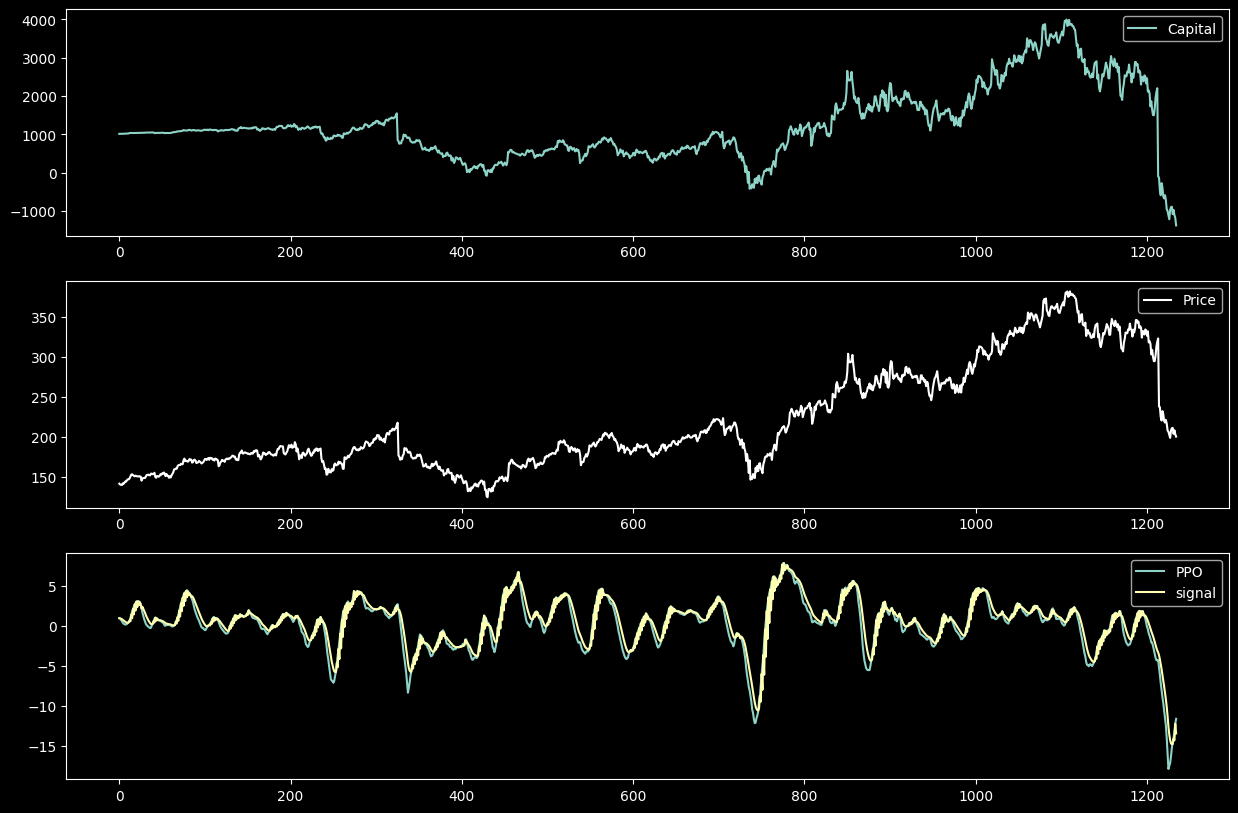

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(15,10));

ax[0].plot([day[0] for day in fuziy_strategy._days.values()][-len(fuziy_strategy.ppo_indicator):])
ax[0].legend(['Capital']);
ax[1].plot(fuziy_strategy.prices[-len(fuziy_strategy.ppo_indicator):], color='white');
ax[1].legend(['Price']);
ax[2].plot(fuziy_strategy.ppo_indicator);
ax[2].legend(['PPO', 'signal']);

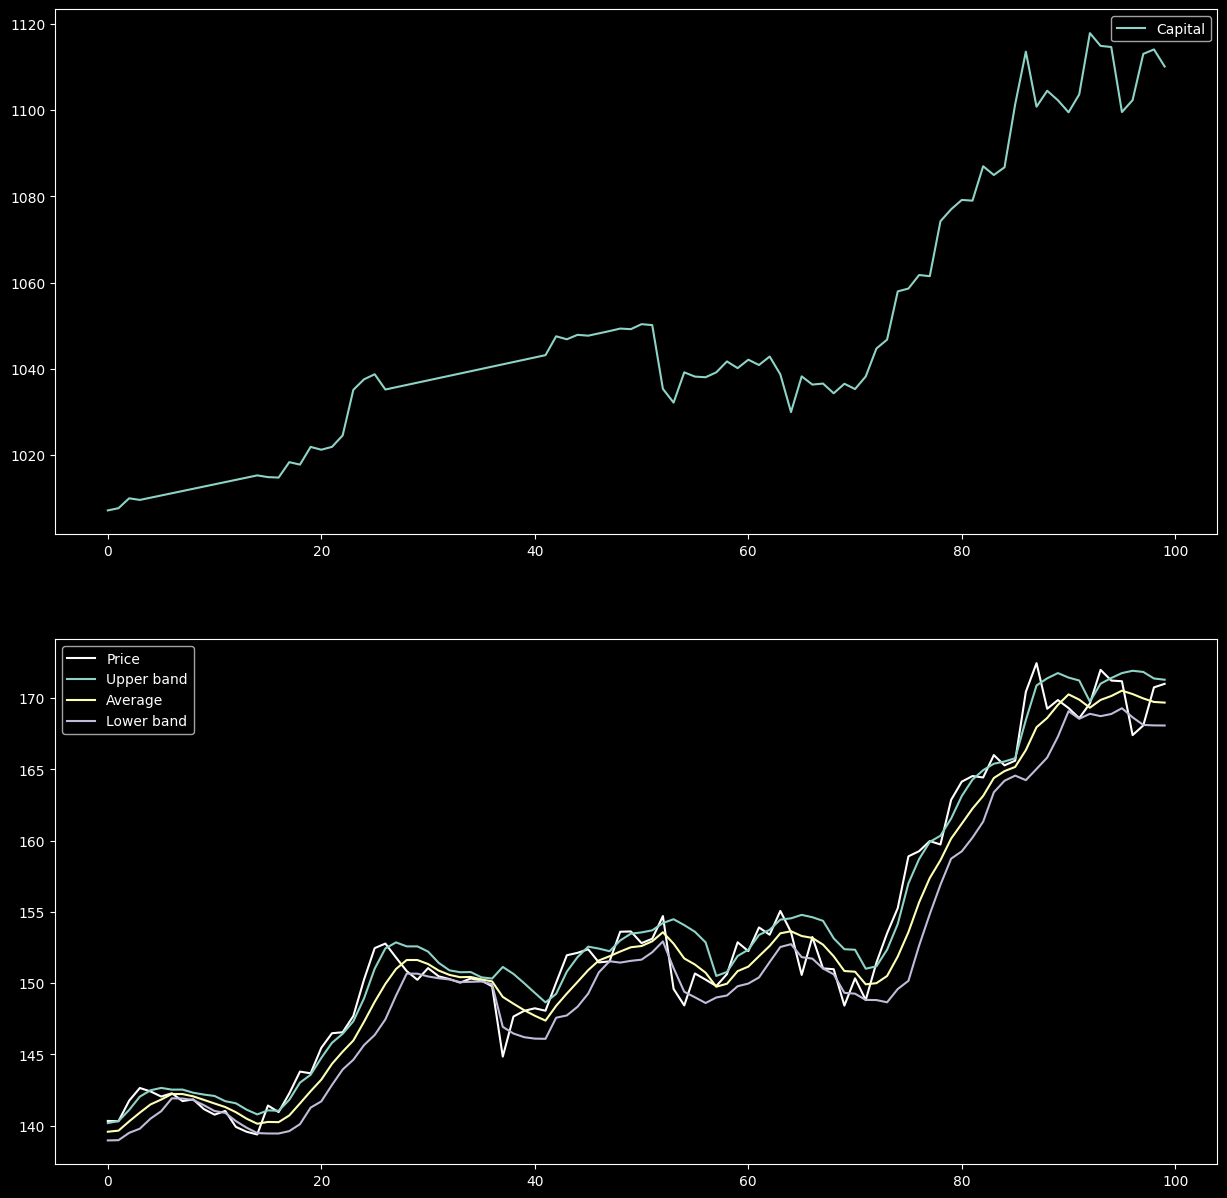

In [12]:
# Plot do gráfico
fig, ax = plt.subplots(2, 1, figsize=(15,15));

shift = -len(fuziy_strategy.bbands_indicator)
ax[0].plot([day[0] for day in fuziy_strategy._days.values()][shift:100+shift])
ax[0].legend(['Capital']);
ax[1].plot(fuziy_strategy.prices[shift:100+shift], color='white');
ax[1].plot(fuziy_strategy.bbands_indicator[:100]);
ax[1].legend(['Price', 'Upper band', 'Average', 'Lower band']);

In [13]:
fuziy_strategy = FuziyStrategy()

print(evaluateHist(fuziy_strategy, {'NKE': 'NKE.csv'}))

Gross Profit: $1301.52
Gross Loss: $-11.25
Gross Total: $1290.27

Number of trades: 12
Hitting Ratio: 50.00%
Number of profit trades: 6
Number of loss trades: 6
Average number of events per trade: 93.83

Max win trade: $1284.15
Avg win trade: $216.92
Max loss trade: $-3.24
Avg loss trade: $-1.87
Avg all trades: $107.52
Win/Loss ratio: 115.72

Max Profit: $2920.43
Max Profit High/Low: $3087.76
Max Drawdown: $-326.73
Max Drawdown High/Low: $-349.45

Max Allocation: $4379.30
Avg Allocation: $460.16
Max Cash Required (margin): $4379.30

Gross Total: $1290.27
Total Fees: $47.00
Total Taxes: $247.83
Net Total: $995.44

Gross Return: 35.80%
Average Return: 2.98%
Net Return: 23.40%
Net Return Avg Alocation: 216.33%

Number of days: 1260
Initial Capital: $1000.00
Risk Free Rate: 13.75% yearly/0.0511% daily
Total Carry: $-418.56
Net Total + Carry: $576.88
Net Return Capital: 57.69%
Net Return Capital Yearly: 9.54%




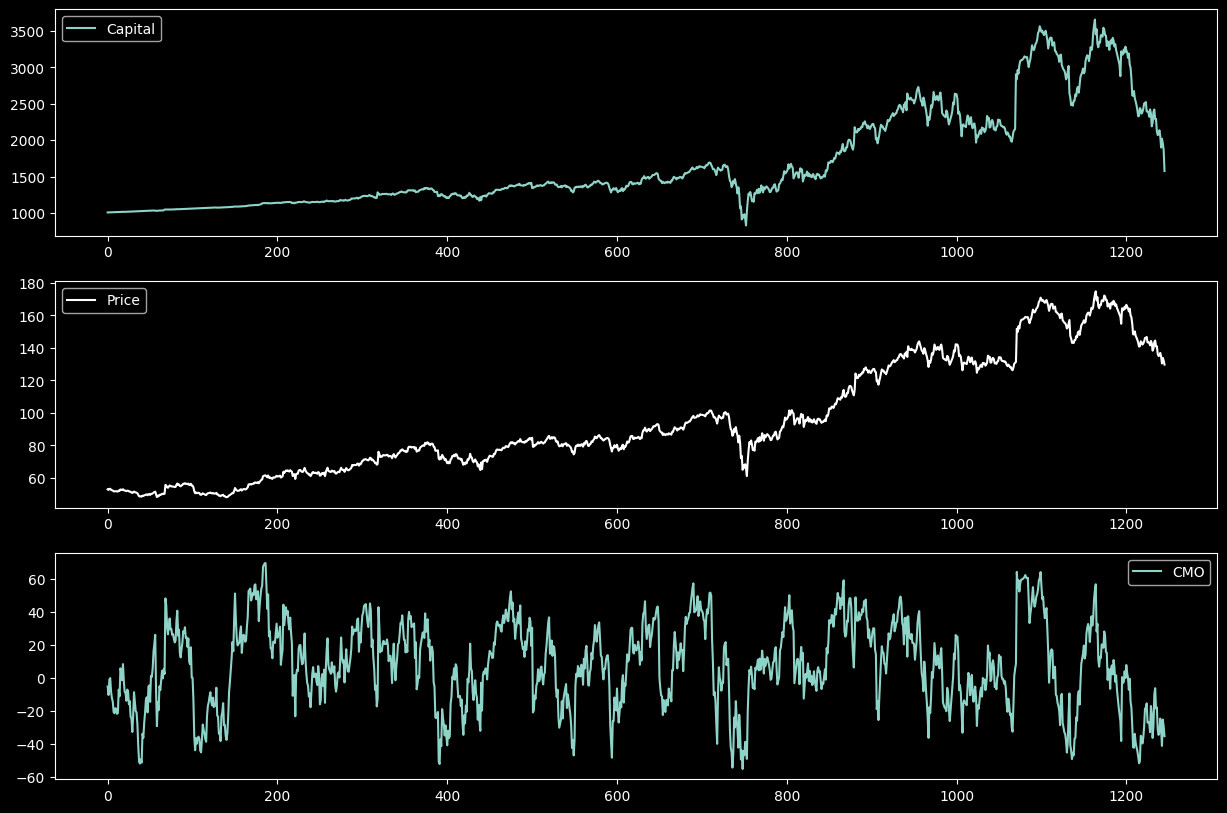

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(15,10));

ax[0].plot([day[0] for day in fuziy_strategy._days.values()][-len(fuziy_strategy.cmo_indicator):])
ax[0].legend(['Capital']);
ax[1].plot(fuziy_strategy.prices[-len(fuziy_strategy.cmo_indicator):], color='white');
ax[1].legend(['Price']);
ax[2].plot(fuziy_strategy.cmo_indicator);
ax[2].legend(['CMO', 'signal']);

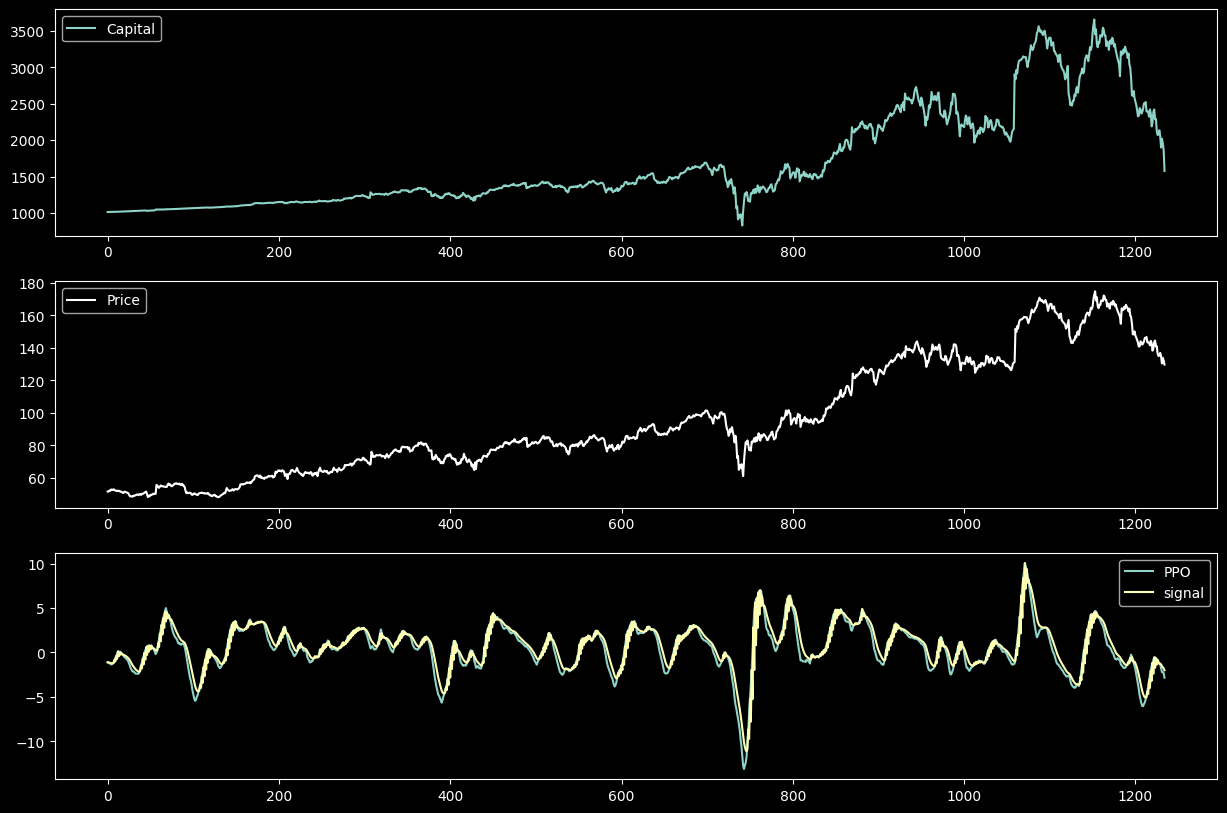

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(15,10));

ax[0].plot([day[0] for day in fuziy_strategy._days.values()][-len(fuziy_strategy.ppo_indicator):])
ax[0].legend(['Capital']);
ax[1].plot(fuziy_strategy.prices[-len(fuziy_strategy.ppo_indicator):], color='white');
ax[1].legend(['Price']);
ax[2].plot(fuziy_strategy.ppo_indicator);
ax[2].legend(['PPO', 'signal']);

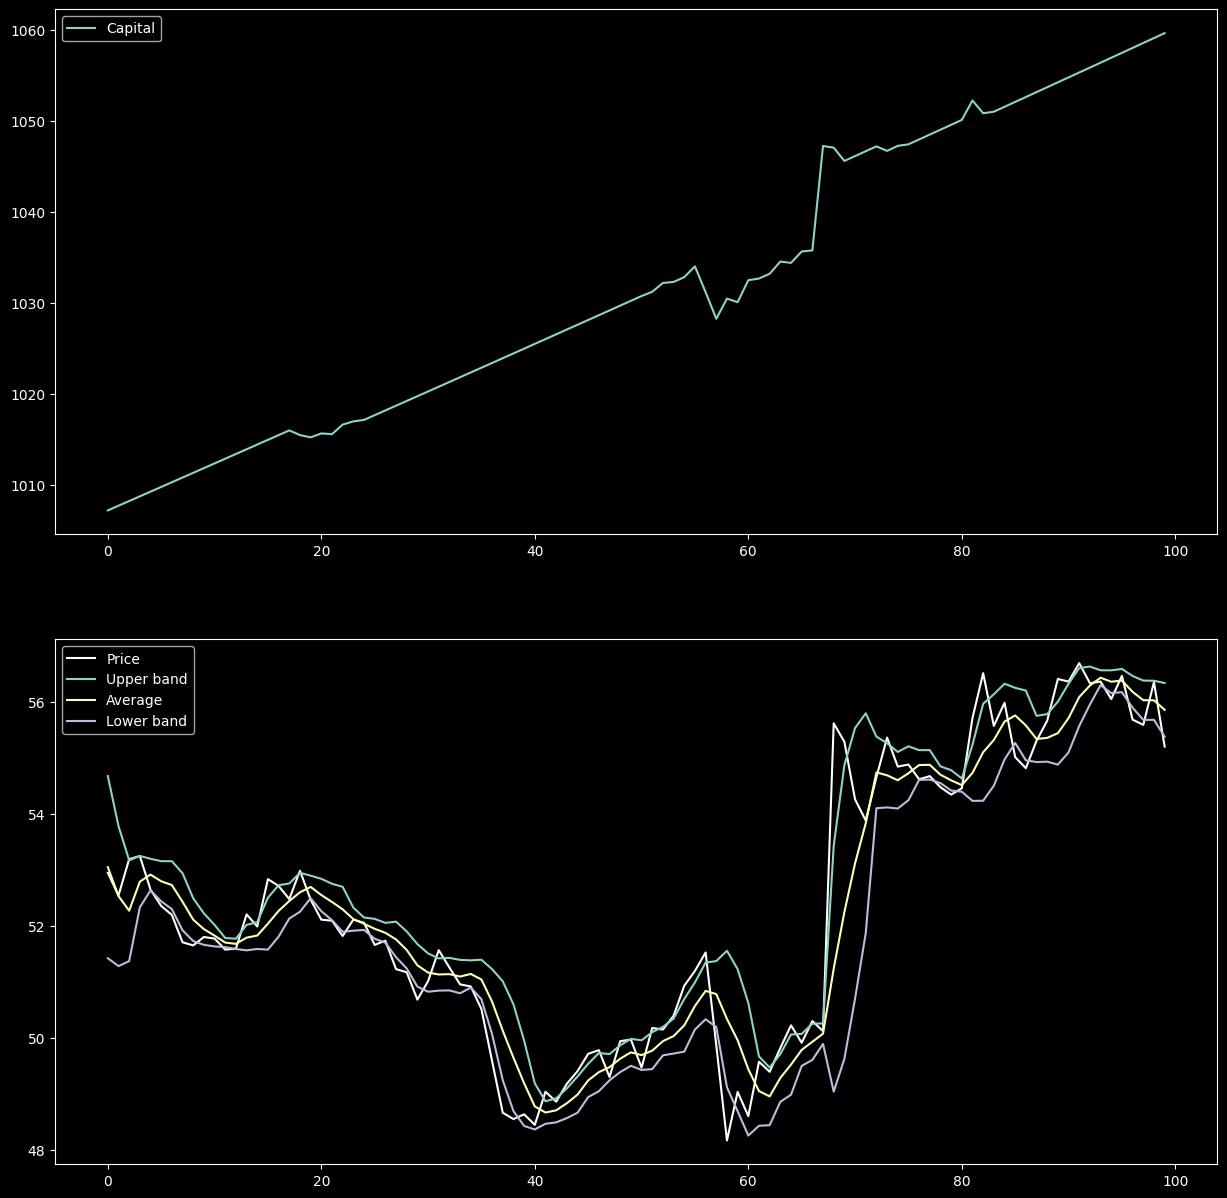

In [16]:
# Plot do gráfico
fig, ax = plt.subplots(2, 1, figsize=(15,15));

shift = -len(fuziy_strategy.bbands_indicator)
ax[0].plot([day[0] for day in fuziy_strategy._days.values()][shift:100+shift])
ax[0].legend(['Capital']);
ax[1].plot(fuziy_strategy.prices[shift:100+shift], color='white');
ax[1].plot(fuziy_strategy.bbands_indicator[:100]);
ax[1].legend(['Price', 'Upper band', 'Average', 'Lower band']);